In [1]:
# %load_ext cudf.pandas
# import pandas as pd
import cudf as pd
from tqdm.auto import tqdm,trange
import torch

In [2]:
def import_labelled_data(path="data/labelled/data.json", group_relevant=True):
    data = pd.read_json(path, encoding="latin-1")
    if group_relevant:
        data["class"] = data["class"].apply(
            lambda x: "relevant" if x != "irrelevant" else x
        )
    return data


print("Loading data...")

data = import_labelled_data(
    path="../../data/level-0.5/data.json", group_relevant=False
)

print("Data loaded.")

data = data.sample(frac=1).reset_index(drop=True)

# data = data.sample(2500)

data.info()
data.head()

Loading data...


/workspace/GreyLit/venv/lib/python3.10/site-packages/cudf/io/json.py:108: UserWarning: Using CPU via Pandas to read JSON dataset, this may be GPU accelerated in the future
  warnings.warn(


Data loaded.
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 19284 entries, 0 to 19283
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   url           19284 non-null  object
 1   text          19284 non-null  object
 2   relevance     19284 non-null  object
 3   multiclasses  19284 non-null  list
dtypes: list(1), object(3)
memory usage: 1.3+ GB


,url,text,relevance,multiclasses
0,https://mglsd.go.ug/wp-content/uploads/2023/07...,"THE REPUBLIC OF UGANDA MINISTRY OF GENDER, LAB...",irrelevant,[]
1,https://www.conservationevidence.com/individua...,Plant new hedges Provide or retain set‐aside a...,relevant,[Insects]
2,http://www.world-psi.org/sites/default/files/d...,RAPPORT SPÉCIAL DE LA PSI : l’Accord sur le co...,irrelevant,[]
3,https://yanceyfamilygenealogy.org/Family_Bible...,The Family Bible Preservation Project's - Fami...,irrelevant,[]
4,https://budget.finance.go.ug/sites/default/fil...,LG Draft Budget Estimates 2024/25 VOTE: 609 Mb...,irrelevant,[]


In [3]:
def train_test_split(x, y=None, test_size=0.2,shuffle=False):
    split = int(len(x) * (1 - test_size))
    xTrain, xTest = x.iloc[:split], x.iloc[split:]
    if y is not None:
        yTrain, yTest = y.iloc[:split], y.iloc[split:]
        return xTrain, xTest, yTrain, yTest
    return xTrain, xTest


xTrain, xTest, yTrain, yTest = train_test_split(data["text"], data["relevance"])

In [4]:
# from sklearn.feature_extraction.text import HashingVectorizer
from cuml.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(
    stop_words="english"
)


In [5]:
time = %timeit -n1 -r1 -o vectorizer.fit(data['text'].iloc[:100])

print(f"Vectorization took {time.average:.2f} seconds.")
print(f"Vectorization of the whole dataset is estimated to take {time.average * len(data) / 100:.2f} seconds.")

1.39 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Vectorization took 0.00 seconds.
Vectorization of the whole dataset is estimated to take 0.27 seconds.


In [6]:
time = %timeit -n1 -r1 -o vectorizer.transform(data['text'].iloc[:200])

print(f"Vectorization took {time.average:.2f} seconds.")
print(f"Vectorization of the whole dataset is estimated to take {time.average * len(data) / 200:.2f} seconds.")

33.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Vectorization took 33.29 seconds.
Vectorization of the whole dataset is estimated to take 3209.45 seconds.


In [7]:
print("Vectorizing data...")

#* took 1min30s in cudf+cuml, then up to 1min40 for yTrain
#* and 1min13s in pandas+cuml, then up to 1min47 for yTrain

vectorizer = HashingVectorizer(
    stop_words="english"
)

print("Fitting vectorizer...")
vectorizer.fit(data["text"])
print("Vectorizer fit.")


print("Vectorizing data...")
xTrainVector = vectorizer.transform(xTrain)
print("Training data vectorized.")
xTestVector = vectorizer.transform(xTest)
print("Testing data vectorized.")

yTrainVector = (yTrain=='relevant').astype(int)
yTestVector = (yTest=='relevant').astype(int)


Vectorizing data...
Fitting vectorizer...
Vectorizer fit.
Vectorizing data...
Training data vectorized.
Testing data vectorized.


In [8]:
xTrainVector.shape

(15427, 1048576)

In [9]:
from LazyTextDataset import LazyTextDataset

train_dataset = LazyTextDataset(xTrainVector, yTrainVector,device='cuda:0')
test_dataset = LazyTextDataset(xTestVector, yTestVector,device='cuda:0')

In [10]:
if vectorizer.__class__.__name__ == "HashingVectorizer":
    VOCAB_SIZE = vectorizer.n_features
else: # tfidf or count
    VOCAB_SIZE = len(vectorizer.vocabulary_)

NUM_CLASSES = len(data["relevance"].unique())

In [11]:
from torch import nn
from torch.nn import functional

torch.multiprocessing.set_start_method('spawn')
torch.set_default_device('cuda:0')
torch.cuda.set_device(0)

In [28]:
from torch.utils.data import DataLoader

def sparse_collate_fn(batch):
    print(batch)
    x = torch.stack([x for x, y in batch])
    y = torch.stack([y for x, y in batch])
    return x, y


train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=sparse_collate_fn, shuffle=True,generator=torch.Generator(device='cuda'),num_workers=0)


In [29]:
from LogisticRegressionClassifier import LogisticRegressionClassifier

model = LogisticRegressionClassifier(vocab_size=VOCAB_SIZE,hidden_dim=5)
model.to('cuda:0')
print(model)

LogisticRegressionClassifier(
  (linear): Linear(in_features=1048576, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_fn = nn.BCEWithLogitsLoss()

In [31]:
from IPython.display import clear_output
from torch.amp import GradScaler, autocast

EPOCHS = 25
scaler = GradScaler()


with trange(EPOCHS) as epochs:
    for epoch in epochs:
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch",leave=False,position=0):
        # for x, y in train_loader:

            with autocast(device_type='cuda',dtype=torch.float16):
                optimizer.zero_grad()
                y_pred = model(x)
                loss = loss_fn(y_pred[:,0], y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        epochs.set_postfix(loss=loss.item())

clear_output()
print('Completed Training.')

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25:   0%|          | 0/121 [00:00<?, ?batch/s]

[(tensor(indices=tensor([[      0,       0,       0,       0,       0,       0,
                              0,       0,       0,       0,       0,       0,
                              0,       0,       0,       0,       0,       0,
                              0,       0,       0,       0,       0,       0,
                              0,       0,       0,       0,       0,       0,
                              0,       0,       0,       0,       0,       0,
                              0,       0,       0,       0,       0,       0,
                              0,       0,       0,       0,       0,       0,
                              0,       0,       0,       0,       0,       0,
                              0,       0,       0,       0,       0,       0,
                              0,       0,       0],
                       [  17987,   44647,   56144,   59409,   62855,   70993,
                          72242,   83224,  118442,  129889,  172875,  180823,
          

RuntimeError: reshape is not implemented for sparse tensors

In [ ]:
dir(xVector)

['A',
 'H',
 'T',
 '__abs__',
 '__add__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__idiv__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmatmul__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_add',
 '_add_sparse',
 '_arg_min_or_max',
 '_arg_min_or_max_axis',
 '_arg_minor_reduce',
 '_argmax_argmin_code',
 '_asindices',
 '_comparison',
 '_compressed_sparse_matrix__get_has_canonical_format',
 '_compressed_sparse_matrix__ge

In [17]:
with torch.no_grad():
    model.eval()

    xTestTensor, yTestTensor = test_dataset[:]
    yTestTensor = yTestTensor[:,1]

    yPred = model(xTestTensor)

    yPred = torch.argmax(yPred,dim=1).cpu().numpy()

MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /tmp/pip-build-env-plvhtgkx/overlay/lib/python3.10/site-packages/librmm/include/rmm/mr/device/cuda_memory_resource.hpp:60: cudaErrorMemoryAllocation out of memory

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(yTestVector, yPred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2092
           1       1.00      1.00      1.00      1765

    accuracy                           1.00      3857
   macro avg       1.00      1.00      1.00      3857
weighted avg       1.00      1.00      1.00      3857



Accuracy: 0.9992221934145709
F1: 0.9991503823279524
Precision: 0.9988674971687429
Recall: 0.9994334277620397


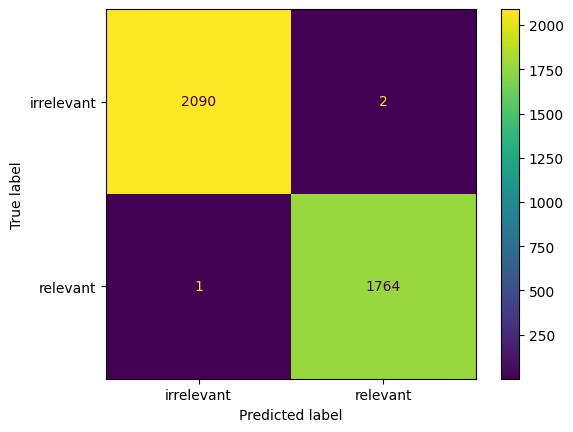

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score

print(f"Accuracy: {accuracy_score(yTestVector, yPred)}")
print(f"F1: {f1_score(yTestVector, yPred)}")
print(f"Precision: {precision_score(yTestVector, yPred)}")
print(f"Recall: {recall_score(yTestVector, yPred)}")

cm = confusion_matrix(yTestVector, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["irrelevant","relevant"])
disp.plot()

import matplotlib.pyplot as plt

plt.show()

In [23]:
import pickle,os

if not os.path.exists("models/vectorizers"):
    os.makedirs("models/vectorizers")

with open("models/vectorizers/hashing_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [24]:
torch.save(model.state_dict(), "models/LogisticRegression.pth")

In [25]:
text = """Shark catch rates are higher in pelagic longline fisheries than in any other fishery, and sharks are
typically discarded (bycatch) at sea. The post-release fate of discarded sharks is largely
unobserved and could pose a significant source of unquantified mortality that may change stock
assessment outcomes and prevent sound conservation and management advice. This study
assessed post-release mortality rates of blue (Prionace glauca), bigeye thresher (Alopias
superciliosus), oceanic whitetip (Carcharhinus longimanus), silky (C. falciformis) and shortfin
mako (Isurus oxyrhincus) sharks discarded in the Hawaii deep-set and American Samoa longline
fisheries targeting tuna in the central Pacific Ocean. The impacts on survival rates were
examined considering species, fishery, fishing gear configuration, handling method, animal
condition at capture and at release, and the amount of trailing fishing gear remaining on
discarded sharks. Bayesian survival analysis showed that the condition at release (good vs.
injured), branchline leader material, and the amount of trailing fishing gear left on the animals
were among the factors that had the largest effect on post-release fate—animals captured on
monofilament branchline leaders and released in good condition without trailing fishing gear had
the highest rates of survival. This study shows that fisher behavior can have a significant impact
on pelagic shark post-release mortality. Ensuring that sharks are handled carefully and released
with minimal amounts of trailing fishing gear may reduce fishing mortality on shark populations."""

text2 = """NumPy is an essential package for high-performance scientific computing and data analysis in the Python ecosystem. It is the foundation of many higher-level tools such as Pandas and scikit-learn.

TensorFlow also uses NumPy arrays as the foundation for building Tensor objects and graph flow for deep learning tasks. These heavily rely on linear algebra operations on large lists, vectors, and matrices of numbers.

NumPy is faster because it uses vectorized implementation, and many of its core functions are written in C."""

In [31]:
v = vectorizer.transform(pd.Series([text]))
t = torch.tensor(v.todense(), dtype=torch.float32)

In [32]:
model(t)

tensor([[8.3146e-04, 9.9857e-01]], device='cuda:0', grad_fn=<SigmoidBackward0>)